In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import plotly
import plotly.graph_objs as go
from pandas.plotting import scatter_matrix
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

#%matplotlib inline
plt.rcParams["figure.figsize"] = [15,10]

# reading the data
df = pd.read_csv("Dummydata_v2.csv",index_col='id')

# preprocessing
math = df.loc[:,"grade1_maths":"grade10_maths"]
science = df.loc[:,"grade1_science":"grade10_science"]
language = df.loc[:,"grade1_language":"grade10_language"]
tgt_cols = ['grade1_maths','grade1_science','grade1_language']
math_cols = ['grade1_maths','grade2_maths','grade3_maths','grade4_maths','grade5_maths','grade6_maths','grade7_maths','grade8_maths','grade9_maths','grade10_maths']
science_cols = ['grade1_science','grade2_science','grade3_science','grade4_science','grade5_science','grade6_science','grade7_science','grade8_science','grade9_science','grade10_science']
language_cols = ['grade1_language','grade2_language','grade3_language','grade4_language','grade5_language','grade6_language','grade7_language','grade8_language','grade9_language','grade10_language']
df4c = df.loc[:,tgt_cols]

df['avg_math'] = math.mean(axis=1)
df['avg_science'] = science.mean(axis=1)
df['avg_language'] = language.mean(axis=1)

# visualize the input data
pairwise = pd.DataFrame(
    squareform(pdist(df.loc[:,tgt_cols])),
    columns = df4c.index,
    index = df4c.index
)

dist_flat = pairwise.to_numpy().flatten('F')

plt.figure(figsize=(10,7))
plt.hist(dist_flat,bins=np.arange(100))
plt.title('Distance spread of training data')
plt.savefig('TrainData_spread.png')

#run clustering algorithm
km = KMeans(n_clusters=3,init='random',n_init=10,max_iter=300,tol=1e-04,random_state=0)
df['label_km'] = km.fit_predict(df4c)

#3d visualization of clustering output
def getTrace(x, y, z, c, label, s=2):
    trace_points = go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(size=s, line=dict(color='rgb(0, 0, 0)', width=0.5), color=c, opacity=1),
        name=label
    )
    return trace_points;

def showGraph(title, x_colname, x_range, y_colname, y_range, z_colname, z_range, traces):
    layout = go.Layout(
        title=title,
        scene = dict(
            xaxis=dict(title=x_colname, range = x_range),
            yaxis=dict(title=y_colname, range = y_range),
            zaxis=dict(title=z_colname, range = z_range)
            )
        )

    fig = go.Figure(data=traces, layout=layout)
    plotly.offline.plot(fig)
    
t1 = getTrace(df[df.label_km == 0].grade1_maths, df[df.label_km ==0].grade1_science, df[df.label_km == 0].grade1_language, s= 4, c='blue', label = '0')
t2 = getTrace(df[df.label_km == 1].grade1_maths, df[df.label_km ==1].grade1_science, df[df.label_km == 1].grade1_language, s= 4, c='green', label = '1')
t3 = getTrace(df[df.label_km == 2].grade1_maths, df[df.label_km ==2].grade1_science, df[df.label_km == 2].grade1_language, s= 4, c='red', label = '2')

x=df.grade1_maths
y=df.grade1_science
z=df.grade1_language
showGraph("Clustering results", "Maths", [min(x),max(x)], "Science", [min(y),max(y)], "Language", [min(z)-1,max(z)], [t1,t2,t3])

### Classification of new data
def train_test_split(data,test_ratio):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(data))
    test_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_size]
    train_indices = shuffled_indices[test_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

test_ratio = 0.2
test_size = int(len(df)*test_ratio)
df_train,df_test = train_test_split(df,test_ratio)

scatter_matrix(df[tgt_cols],figsize=(15,10));
plt.savefig('Attribute_Correlation.png')

Y_train = df_train['label_km'].values
available_cols = ['grade1_maths','grade1_science','grade1_language']
X_train = df_train.loc[:,available_cols].values

Y_test = df_test['label_km'].values
X_test = df_test.loc[:,available_cols].values

k_range = range(1,20)
best_k = 0
acc_threshold = 0.8
scores = {}
scores_list = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,Y_train)
    y_pred = knn.predict(X_test)
    acc_k=metrics.accuracy_score(Y_test,y_pred)
    if(acc_k>acc_threshold):
        acc_threshold = acc_k
        best_k=k

if(best_k==0):
    plt.title('Not enough data to predict')
    plt.savefig('PredictionOutput.png')
else:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,Y_train)
    out_id = np.random.randint(1,test_size)    
    y_pred = knn.predict(X_test[out_id].reshape(1,-1))
    dft = df.groupby('label_km').mean().transpose()
    dft.loc[math_cols,:].plot.bar(rot=0);
    plt.title('Trend for Maths (Target label = ' + str(y_pred[0]) + ')')
    plt.savefig('PredictionOutput (Math).png')    
    dft.loc[science_cols,:].plot.bar(rot=0);
    plt.title('Trend for Science (Target label = ' + str(y_pred[0]) + ')')
    plt.savefig('PredictionOutput (Science).png')
    dft.loc[language_cols,:].plot.bar(rot=0);
    plt.title('Trend for Language (Target label = ' + str(y_pred[0]) + ')')
    plt.savefig('PredictionOutput (Language).png')


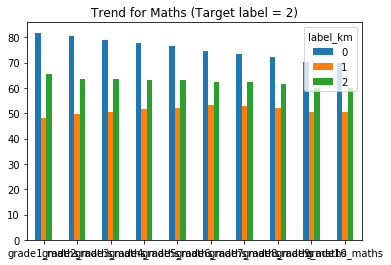

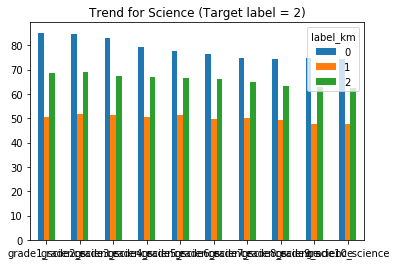

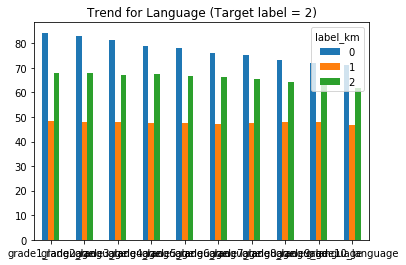

In [3]:
if(best_k==0):
    plt.title('Not enough data to predict')
    plt.savefig('PredictionOutput.png')
else:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train,Y_train)
    out_id = np.random.randint(1,test_size)    
    y_pred = knn.predict(X_test[out_id].reshape(1,-1))
    dft = df.groupby('label_km').mean().transpose()
    dft.loc[math_cols,:].plot.bar(rot=0);
    plt.title('Trend for Maths (Target label = ' + str(y_pred[0]) + ')')
    plt.savefig('PredictionOutput (Math).png')    
    dft.loc[science_cols,:].plot.bar(rot=0);
    plt.title('Trend for Science (Target label = ' + str(y_pred[0]) + ')')
    plt.savefig('PredictionOutput (Science).png')
    dft.loc[language_cols,:].plot.bar(rot=0);
    plt.title('Trend for Language (Target label = ' + str(y_pred[0]) + ')')
    plt.savefig('PredictionOutput (Language).png')
